# Test 5 -  Exploring Transformers

**Author:** [Thanveer ahamed](developer.thanveer@gmail.com | https://github.com/Thanveerahmd)<br>
**Date created:** 2023/03/31<br>
**Description:** Compact Convolutional Transformer for detecting simulated strong gravitational lensing images with and without substructure.

# Imports

In [ ]:
import tensorflow as tf
import pdb
import numpy as np
import tensorflow_addons as tfa
import os
import itertools
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import binarize

# Data Loading

In [3]:
DATAPATH = './lenses' # Root path of data
OUTPATH = './output' # Storing output
os.makedirs(OUTPATH, exist_ok=True)
SAVEPATH = os.path.join(OUTPATH, 'weights') # For storing model weights
os.makedirs(SAVEPATH)
CKP_PATH = os.path.join(SAVEPATH, 'ckp')

CATEGORIES = ('no_sub', 'sub') # Labels: no_sub=0, sub=1

In [4]:
def load_data(root, categories):
    """Loads examples and labels into numpy arrays  """
    x, y = [], []

    for index, category in enumerate(categories):
        for filename in os.scandir(os.path.join(root, category)):
            filedata = np.asarray(Image.open(filename.path))
            x.append(filedata)
            y.append(index) # Labels: no_sub=0, sub=1
  
    x = np.expand_dims(np.array(x), axis=-1) # add channel axis
    y = np.array(y)

    return x, y

In [5]:
X, y = load_data(DATAPATH, CATEGORIES)

print(f'Shape of X: {X.shape}')
print(f'Shape of Y: {y.shape}')

Shape of X: (10000, 150, 150, 1)
Shape of Y: (10000,)


In [6]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Split train data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42)


In [7]:
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of X_val: {X_val.shape}')
print(f'Shape of y_val: {y_val.shape}')

Shape of X_train: (8100, 150, 150, 1)
Shape of y_train: (8100,)
Shape of X_test: (1000, 150, 150, 1)
Shape of y_train: (8100,)
Shape of X_val: (900, 150, 150, 1)
Shape of y_val: (900,)


## Visualize data

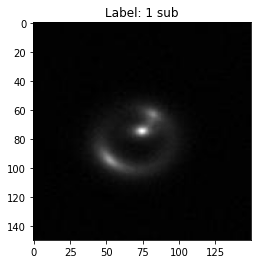

In [8]:
# Display random instance of data
idx = np.random.default_rng().integers(0, len(X_train))
_ = plt.imshow(X_train[idx].squeeze(), cmap='gray')
_ = plt.title(f'Label: {y_train[idx]} {CATEGORIES[y_train[idx]]}')

# Data pre-processing 

In [9]:
def standardize(x, datatype, root):
    '''Standardize image examples'''
    # Make image contrast similar across all images
    x = x - np.mean(x, axis=(1, 2), keepdims=True)
  
    if datatype == 'train':
        # Center around origin
        mean = np.mean(x, axis=(0, 1, 2), keepdims=True)
        std = np.std(x, axis=(0, 1, 2), keepdims=True)

        # Save mean and std for validation/test data
        np.save(os.path.join(root, 'mean'), mean)
        np.save(os.path.join(root, 'std'), std)
    else:
        try:
            mean = np.load(os.path.join(root, 'mean.npy'))
            std = np.load(os.path.join(root, 'std.npy'))
        except FileNotFoundError as _:
            raise FileNotFoundError('Standardizing info files (mean.npy and std.npy) not found')
  
    x = (x - mean) / std
    return x

In [10]:
# Standardize data
X_train = standardize(X_train, 'train', OUTPATH)
X_test = standardize(X_test, 'test', OUTPATH)
X_val = standardize(X_val, 'val', OUTPATH)

# Compact Convolutional Transformer Model 

## Hyper parameters

In [11]:
positional_emb = True
conv_layers = 2
projection_dim = 128

num_heads = 2
transformer_units = [
    projection_dim,
    projection_dim,
]
transformer_layers = 2
stochastic_depth_rate = 0.1

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 50
image_size = X_train.shape[1]

input_shape = (150,150, 1)

## Model architecture

In [12]:
class CCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=conv_layers,
        num_output_channels=[64, 128],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # This is our tokenizer.
        self.conv_model = keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]),
        )
        return reshaped

    def positional_embedding(self, image_size):
        # Positional embeddings are optional in CCT. Here, we calculate
        # the number of sequences and initialize an `Embedding` layer to
        # compute the positional embeddings later.
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, image_size, 1))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = tf.shape(dummy_outputs)[1]
            projection_dim = tf.shape(dummy_outputs)[-1]

            embed_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim
            )
            return embed_layer, sequence_length
        else:
            return None

In [13]:
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (tf.shape(x).shape[0] - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

In [14]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [15]:
# Note the rescaling layer. These layers have pre-defined inference behavior.
data_augmentation = keras.Sequential(
    [RandomFlip(),
     RandomRotation(0.5),
     RandomZoom(height_factor=0.2, width_factor=0.2)],
    name="data_augmentation",
)

In [16]:
def create_cct_model(
    image_size=image_size,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):

    inputs = layers.Input(input_shape)

    # Augment data.
    augmented = data_augmentation(inputs)

    # Encode patches.
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(augmented)

    # Apply positional embedding.
    if positional_emb:
        pos_embed, seq_length = cct_tokenizer.positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)
        position_embeddings = pos_embed(positions)
        encoded_patches += position_embeddings

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])

    # Apply sequence pooling.
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    attention_weights = tf.nn.softmax(layers.Dense(1)(representation), axis=1)
    weighted_representation = tf.matmul(
        attention_weights, representation, transpose_a=True
    )
    weighted_representation = tf.squeeze(weighted_representation, -2)

    # Classify outputs.
    logits = layers.Dense(1, activation='sigmoid', name='classifier')(weighted_representation)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

## utility functions 

In [17]:
class RandomSampleGenerator(keras.utils.Sequence):
    '''
    Generates batches containing equal number of positive and negative examples
    to rectify any class imbalance in data
    '''
    def __init__(self, x, y, batch_size, seed=None):
        self.x_positive = x[y == 1]
        self.y_positive = y[y == 1]

        self.x_negative = x[y == 0]
        self.y_negative = y[y == 0]

        self.epoch_length = len(x) // batch_size
        self.batch_size = batch_size
        self.seed = seed
        self.reset()

    def reset(self):
        # Reset random number generator
        self.rng = np.random.default_rng(self.seed)

    def __len__(self):
        return self.epoch_length

    def __getitem__(self, idx):
        # Positive samples
        batch_positive_indices = self.rng.choice(self.x_positive.shape[0],
                                                 self.batch_size // 2,
                                                 replace=False)
        batch_x_positive = self.x_positive[batch_positive_indices]
        batch_y_positive = self.y_positive[batch_positive_indices]

        # Negative samples
        batch_negative_indices = self.rng.choice(self.x_negative.shape[0],
                                                 int(np.ceil(self.batch_size / 2)),
                                                 replace=False)
        batch_x_negative = self.x_negative[batch_negative_indices]
        batch_y_negative = self.y_negative[batch_negative_indices]

        # Concat both samples
        batch_x = np.concatenate((batch_x_positive, batch_x_negative))
        batch_y = np.concatenate((batch_y_positive, batch_y_negative))

        return batch_x, batch_y

In [18]:
class TrackBestPerformance(keras.callbacks.Callback):
    '''
    Callback to keep track of model weights which give best val_auc
    After training completes, the model is assigned with the best model weights
    '''
    def __init__(self, ckp_path, save_every=15, **kwargs):
        super().__init__(**kwargs)
        self.best_auc = 0
        self.best_epoch = -1
        self.best_weights = None
        self.ckp_path = ckp_path
        self.save_every = save_every
  
    def on_epoch_end(self, epoch, logs=None):
        '''Track best val_auc and corresponding weights'''
        current_auc = logs['val_auc']
        if current_auc >= self.best_auc:
            self.best_auc = current_auc
            self.best_epoch = epoch
            self.best_weights = self.model.get_weights()
        if epoch % self.save_every == 0:
            self.model.save_weights(self.ckp_path)
  
    def on_train_end(self, logs=None):
        '''Reassign model weights to the one with the best val_auc'''
        self.model.set_weights(self.best_weights)
        self.model.save_weights(self.ckp_path)
        print(f'\nBest validation AUC is {self.best_auc} '
              f'on epoch #{self.best_epoch + 1}')

# Training the Model

In [19]:
# Instantiate new model
model = create_cct_model()

optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001)

model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.AUC(name='auc')
        ],
    )

model._name  = 'LensCCT'

In [20]:
model.summary()

Model: "LensCCT"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 150, 150, 1)  0          ['input_1[0][0]']                
                                                                                                  
 cct_tokenizer (CCTTokenizer)   (None, 1444, 128)    74304       ['data_augmentation[0][0]']      
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 1444, 128)   0           ['cct_tokenizer[0][0]']    

                                                                                                  
 classifier (Dense)             (None, 1)            129         ['tf.compat.v1.squeeze[0][0]']   
                                                                                                  
Total params: 405,826
Trainable params: 405,826
Non-trainable params: 0
__________________________________________________________________________________________________


In [22]:
train_generator = RandomSampleGenerator(X_train, y_train, batch_size)
callbacks = [TrackBestPerformance(CKP_PATH)]
history = model.fit(train_generator, 
                    validation_data=(X_val, y_val),
                        epochs=num_epochs, 
                    callbacks=callbacks,
                        verbose=1)

Epoch 1/50
253/253 [==============================] - 52s 192ms/step - loss: 0.7053 - accuracy: 1.0000 - auc: 0.5344 - val_loss: 0.6699 - val_accuracy: 1.0000 - val_auc: 0.6190
Epoch 2/50
253/253 [==============================] - 49s 192ms/step - loss: 0.6721 - accuracy: 1.0000 - auc: 0.6176 - val_loss: 0.6446 - val_accuracy: 1.0000 - val_auc: 0.6763
Epoch 3/50
253/253 [==============================] - 50s 199ms/step - loss: 0.6523 - accuracy: 1.0000 - auc: 0.6654 - val_loss: 0.6229 - val_accuracy: 1.0000 - val_auc: 0.7115
Epoch 4/50
253/253 [==============================] - 52s 204ms/step - loss: 0.6292 - accuracy: 1.0000 - auc: 0.7006 - val_loss: 0.7798 - val_accuracy: 1.0000 - val_auc: 0.8052
Epoch 5/50
253/253 [==============================] - 52s 206ms/step - loss: 0.5860 - accuracy: 1.0000 - auc: 0.7532 - val_loss: 0.5150 - val_accuracy: 1.0000 - val_auc: 0.8520
Epoch 6/50
253/253 [==============================] - 53s 208ms/step - loss: 0.5599 - accuracy: 1.0000 - auc: 0.783

253/253 [==============================] - 53s 211ms/step - loss: 0.1890 - accuracy: 1.0000 - auc: 0.9783 - val_loss: 0.0938 - val_accuracy: 1.0000 - val_auc: 0.9949
Epoch 48/50
253/253 [==============================] - 53s 211ms/step - loss: 0.1826 - accuracy: 1.0000 - auc: 0.9798 - val_loss: 0.3078 - val_accuracy: 1.0000 - val_auc: 0.9781
Epoch 49/50
253/253 [==============================] - 53s 210ms/step - loss: 0.1865 - accuracy: 1.0000 - auc: 0.9788 - val_loss: 0.1140 - val_accuracy: 1.0000 - val_auc: 0.9932
Epoch 50/50
253/253 [==============================] - 53s 211ms/step - loss: 0.1663 - accuracy: 1.0000 - auc: 0.9834 - val_loss: 0.1153 - val_accuracy: 1.0000 - val_auc: 0.9929

Best validation AUC is 0.9949138164520264 on epoch #47


# Model Evaluation

In [24]:
  _, accuracy, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test auc: {round(test_acc * 100, 2)}%")

32/32 [==============================] - 2s 57ms/step - loss: 0.0963 - accuracy: 1.0000 - auc: 0.9954
Test accuracy: 100.0%
Test auc: 99.54%


In [27]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['auc']) 
    plt.plot(history.history['val_auc']) 
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy'], loc='best')
    plt.show()


def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss'], loc='best')
    plt.show()

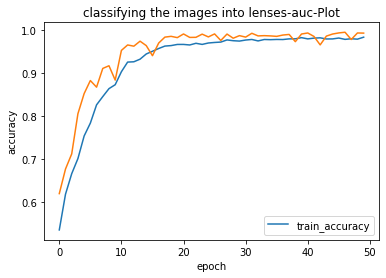

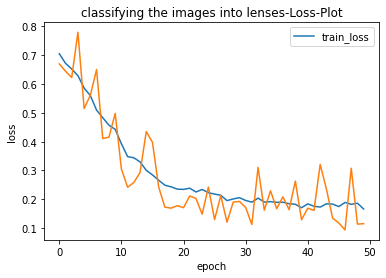

In [30]:
plot_accuracy(history,'classifying the images into lenses-auc-Plot')
plot_loss(history,'classifying the images into lenses-Loss-Plot')

In [52]:
# train your binary classifier and obtain the predicted class labels for your test data
y_pred = model.predict(X_test)

# convert the predicted class labels to binary class labels
y_pred_bin = binarize(y_pred.reshape(1,-1), threshold=0.5)[0]

# generate the classification report
print(classification_report(y_test, y_pred_bin))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       492
           1       0.96      0.96      0.96       508

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000



In [58]:
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_bin)
print(cm)

Confusion Matrix:
[[473  19]
 [ 19 489]]


In [54]:
# Confusion Matrix visualization
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

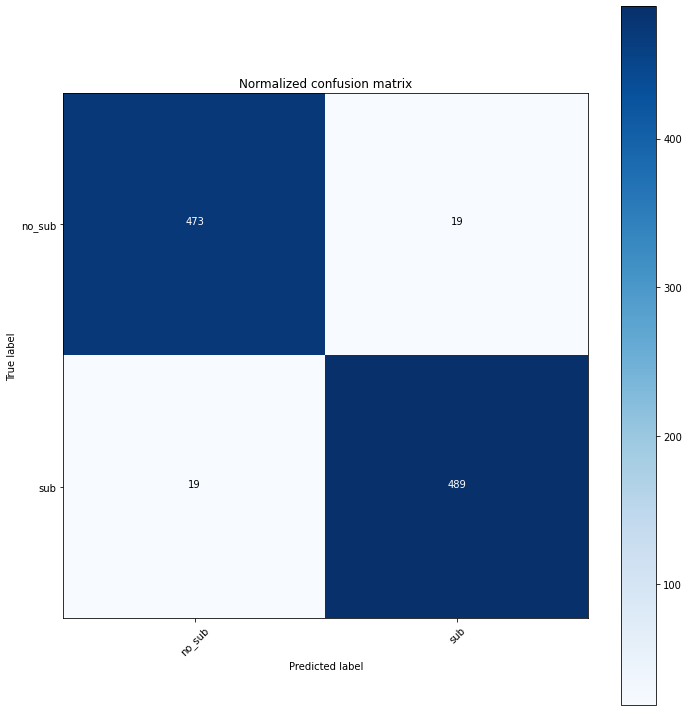

In [61]:
# Plot  confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm, CATEGORIES, normalize=False, title='Normalized confusion matrix')
display()

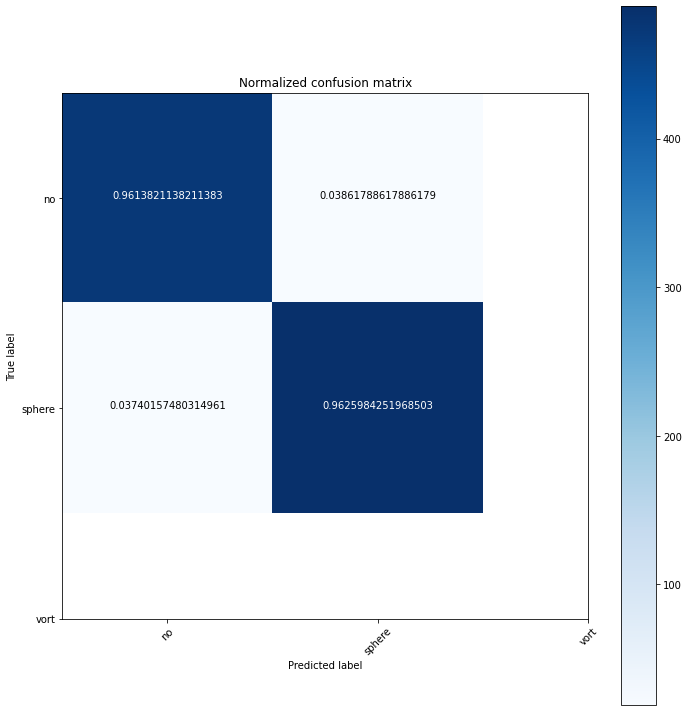

In [62]:
# Plot normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm, classes=['no', 'sphere', 'vort'], normalize=True, title='Normalized confusion matrix')
display()

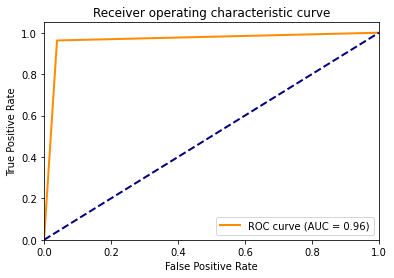

In [76]:
# compute the false positive rate (fpr), true positive rate (tpr), and threshold values for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_bin)

# compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

# save the model

In [77]:
SAVE_MODEL_WEIGHTS_PATH = os.path.join(OUTPATH, 'model_weights') 
os.makedirs(SAVE_MODEL_WEIGHTS_PATH)

In [80]:
model.save_weights(SAVE_MODEL_WEIGHTS_PATH+'\LensCCT.hdf5')